In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

plt.style.use('ggplot')
np.set_printoptions(precision=4)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('precision', 6)

### Load the dataset

In [2]:
train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', parse_dates=['Date'])
test = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv', parse_dates=['Date'])
store = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')

print('train.shape: {}'.format(train.shape))
print('test.shape: {}'.format(test.shape))
print('store.shape: {}'.format(store.shape))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


train.shape: (1017209, 9)
test.shape: (41088, 8)
store.shape: (1115, 10)


### Prepare the store table

In [3]:
# Drop all the rows with store open but zero sales
train = train.drop(train[(train.Sales==0) & (train.Open==1)].index, axis=0)

# For each store, year, and month, drop the abnormal sales

In [4]:
# Convert Competition date information to datetime for comparing
def convert_competition_open(row):
    try:
        date = '{}-{}'.format(int(row['CompetitionOpenSinceYear']), int(row['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan
store['CompetitionOpen'] = store.apply(convert_competition_open, axis=1)
store = store.drop(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'], axis=1)

# Convert Promo2 information to datetime for comparing
def convert_promo2(row):
    try:
        date = '{}{}1'.format(int(row['Promo2SinceYear']), int(row['Promo2SinceWeek']))
        return pd.to_datetime(date, format='%Y%W%w')
    except:
        return np.nan
store['Promo2Since'] = store.apply(convert_promo2, axis=1)
store = store.drop(['Promo2', 'Promo2SinceYear', 'Promo2SinceWeek'], axis=1)

# Add 12 attributes of the months each store is running promo2
months = {
    'Jan': 1,
    'Feb' : 2,
    'Mar' : 3,
    'Apr' : 4,
    'May' : 5,
    'Jun' : 6,
    'Jul' : 7,
    'Aug' : 8,
    'Sept' : 9, 
    'Oct' : 10,
    'Nov' : 11,
    'Dec' : 12
}
def add_promo2_month(interval, month):
    if pd.isnull(interval):
        return np.nan
    else:
        if month in interval.split(','):
            return 1
        else:
            return 0

for month in months.keys():
    store['Promo2_on_month' + '_' + str(months[month])] = store.PromoInterval.apply(add_promo2_month, args=(month,))
store = store.drop('PromoInterval', axis=1)


In [5]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 18 columns):
Store                  1115 non-null int64
StoreType              1115 non-null object
Assortment             1115 non-null object
CompetitionDistance    1112 non-null float64
CompetitionOpen        761 non-null datetime64[ns]
Promo2Since            571 non-null datetime64[ns]
Promo2_on_month_1      571 non-null float64
Promo2_on_month_2      571 non-null float64
Promo2_on_month_3      571 non-null float64
Promo2_on_month_4      571 non-null float64
Promo2_on_month_5      571 non-null float64
Promo2_on_month_6      571 non-null float64
Promo2_on_month_7      571 non-null float64
Promo2_on_month_8      571 non-null float64
Promo2_on_month_9      571 non-null float64
Promo2_on_month_10     571 non-null float64
Promo2_on_month_11     571 non-null float64
Promo2_on_month_12     571 non-null float64
dtypes: datetime64[ns](2), float64(13), int64(1), object(2)
memory usage: 156.9+ KB


### Drop the outliers

In [6]:
# Drop all the rows with store open but zero sales
train = train.drop(train[(train.Sales==0) & (train.Open==1)].index, axis=0)

# For each store, year, and month, drop the abnormal sales
stats = train.groupby('Store').Sales.agg(['mean', 'std']).reset_index()
sales = train[['Store', 'Sales']].copy().reset_index()
sales = pd.merge(sales, stats, on='Store')
sales['z_score'] = (sales['Sales'] - sales['mean']) / sales['std']

index_to_drop = sales.loc[sales.z_score>=3, 'index']
train = train.drop(index_to_drop, axis=0)

### Combine the data for easy processing

In [7]:
train['istestset'] = 0
test['istestset'] = 1
combine = pd.concat([train.drop(['Sales', 'Customers'], axis=1), test.drop('Id', axis=1)], axis=0, ignore_index=True)

### Add the store table information

In [8]:
combine = pd.merge(combine, store, how='left', on='Store')

In [9]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057131 entries, 0 to 1057130
Data columns (total 25 columns):
Store                  1057131 non-null int64
DayOfWeek              1057131 non-null int64
Date                   1057131 non-null datetime64[ns]
Open                   1057120 non-null float64
Promo                  1057131 non-null int64
StateHoliday           1057131 non-null object
SchoolHoliday          1057131 non-null int64
istestset              1057131 non-null int64
StoreType              1057131 non-null object
Assortment             1057131 non-null object
CompetitionDistance    1054398 non-null float64
CompetitionOpen        718946 non-null datetime64[ns]
Promo2Since            532356 non-null datetime64[ns]
Promo2_on_month_1      532356 non-null float64
Promo2_on_month_2      532356 non-null float64
Promo2_on_month_3      532356 non-null float64
Promo2_on_month_4      532356 non-null float64
Promo2_on_month_5      532356 non-null float64
Promo2_on_month_6     

### Fill in missing values

In [10]:
# Fill in Open with mode
combine['Open'] = combine.Open.fillna(1.0)

# Fill in all the promo2 related attributes with -1, which indicates a special case(not participate in promo2)
promo2_related_feats = [_ for _ in combine.columns if 'Promo2' in _]
for feat in promo2_related_feats:
    combine[feat] = combine[feat].fillna(-1)
    
# Fill in the missing values in CompetitionDistance with the max + 1000, which means no nearby competition
combine['CompetitionDistance'] = combine['CompetitionDistance'].fillna(combine.CompetitionDistance.max() + 1000)

# For the missing values in CompetitionOpen, I just chenge it to categorical attribute (with 0 means not open yet, 1 means opened, -1 means unclear)
def convert_CompetitionOpen_cat(row):
    if pd.isnull(row['CompetitionOpen']):
        return -1
    else:
        if row['Date'] >= row['CompetitionOpen']:
            return 1
        else:
            return 0
combine['CompetitionOpen'] = combine.apply(convert_CompetitionOpen_cat, axis=1)

In [11]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057131 entries, 0 to 1057130
Data columns (total 25 columns):
Store                  1057131 non-null int64
DayOfWeek              1057131 non-null int64
Date                   1057131 non-null datetime64[ns]
Open                   1057131 non-null float64
Promo                  1057131 non-null int64
StateHoliday           1057131 non-null object
SchoolHoliday          1057131 non-null int64
istestset              1057131 non-null int64
StoreType              1057131 non-null object
Assortment             1057131 non-null object
CompetitionDistance    1057131 non-null float64
CompetitionOpen        1057131 non-null int64
Promo2Since            1057131 non-null object
Promo2_on_month_1      1057131 non-null float64
Promo2_on_month_2      1057131 non-null float64
Promo2_on_month_3      1057131 non-null float64
Promo2_on_month_4      1057131 non-null float64
Promo2_on_month_5      1057131 non-null float64
Promo2_on_month_6      1057131 n

### Feature engineering

In [12]:
# DayOfWeek
combine['DayOfWeek'] = combine.DayOfWeek.astype(int)

# Date
combine['Date'] = pd.to_datetime(combine.Date)
combine['Year'] = combine.Date.dt.year.astype(int)
combine['Month'] = combine.Date.dt.month.astype(int)
combine['Day'] = combine.Date.dt.day.astype(int)
combine['Week'] = combine.Date.dt.week.astype(int)

# Open ...
# Promo ...

# StateHoliday
combine['StateHoliday'] = combine.StateHoliday.replace({0:'0'}).astype('category').cat.codes

# SchoolHoliday ...

# StoreType
combine['StoreType'] = combine.StoreType.astype('category').cat.codes

# Assortment
combine['Assortment'] = combine.Assortment.astype('category').cat.codes

# Promo2 conver into catigorical feature(with 0 means not on, 1 means on, -1 means not participate)
def create_promo2(row):
    if row['Promo2Since'] == -1:
        return -1
    else:
        month = row['Month']
        if row['Promo2_on_month_' + str(month)] == 1 and row['Date'] > row['Promo2Since']:
            return 1
        else:
            return 0
combine['Promo2'] = combine.apply(create_promo2, axis=1)
combine = combine.drop(promo2_related_feats, axis=1)

combine = combine.drop('Date', axis=1)

combine = pd.get_dummies(combine)

In [13]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057131 entries, 0 to 1057130
Data columns (total 16 columns):
Store                  1057131 non-null int64
DayOfWeek              1057131 non-null int64
Open                   1057131 non-null float64
Promo                  1057131 non-null int64
StateHoliday           1057131 non-null int8
SchoolHoliday          1057131 non-null int64
istestset              1057131 non-null int64
StoreType              1057131 non-null int8
Assortment             1057131 non-null int8
CompetitionDistance    1057131 non-null float64
CompetitionOpen        1057131 non-null int64
Year                   1057131 non-null int64
Month                  1057131 non-null int64
Day                    1057131 non-null int64
Week                   1057131 non-null int64
Promo2                 1057131 non-null int64
dtypes: float64(2), int64(11), int8(3)
memory usage: 115.9 MB


### Prepare the data for modeling

In [14]:
data_train = combine[combine.istestset==0].drop('istestset', axis=1)
label_train = train['Sales']
label_train_log = np.log1p(train['Sales'])
data_test = combine[combine.istestset==1].drop('istestset', axis=1)

### Find the basic setting of the model and Set up the metrics

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from lightgbm.sklearn import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

#### I tried the following 4 settings for the model and choose the best:

- Default objective function without taking log of the target
- Default objective function with taking log of the target
- Custom objective function without taking log of the target
- Custom objective function with taking log of the target

In [16]:
X_train, X_eval, y_train, y_eval = train_test_split(data_train, label_train, test_size=0.1, random_state=0)
X_train, X_eval, y_train_log, y_eval_log = train_test_split(data_train, label_train_log, test_size=0.1, random_state=0)

dataset_train = lgb.Dataset(X_train, y_train)
dataset_eval = lgb.Dataset(X_eval, y_eval, reference=dataset_train)

dataset_train_log = lgb.Dataset(X_train, y_train_log)
dataset_eval_log = lgb.Dataset(X_eval, y_eval_log, reference=dataset_train_log)

In [17]:
num_rounds = 2000
verb_rounds = 100
earlystop_rounds = 100

### Default objective function without taking log of the target

In [18]:
def loss(y_pred, y):
    y = y.get_label()
    n = y.shape[0]
    ind = (y!=0)
    y_pred, y = y_pred[ind], y[ind]
    dis_percent_squared = ((y - y_pred) / y) ** 2
    loss = np.sqrt(dis_percent_squared.sum() / n)
    return 'rmspe', loss, False

lgb.train({}, dataset_train, num_rounds, 
          valid_sets=[dataset_train, dataset_eval], valid_names=['training set', 'validation set'], 
          feval=loss, verbose_eval=verb_rounds, early_stopping_rounds=earlystop_rounds)

Training until validation scores don't improve for 100 rounds.
[100]	training set's rmspe: 0.353539	validation set's rmspe: 0.328529
[200]	training set's rmspe: 0.294888	validation set's rmspe: 0.268289
[300]	training set's rmspe: 0.260906	validation set's rmspe: 0.234064
[400]	training set's rmspe: 0.241588	validation set's rmspe: 0.213323
[500]	training set's rmspe: 0.226319	validation set's rmspe: 0.197813
[600]	training set's rmspe: 0.217571	validation set's rmspe: 0.189241
[700]	training set's rmspe: 0.211076	validation set's rmspe: 0.181455
[800]	training set's rmspe: 0.205693	validation set's rmspe: 0.175445
[900]	training set's rmspe: 0.200428	validation set's rmspe: 0.1696
[1000]	training set's rmspe: 0.19638	validation set's rmspe: 0.165255
[1100]	training set's rmspe: 0.19253	validation set's rmspe: 0.16175
[1200]	training set's rmspe: 0.190344	validation set's rmspe: 0.159234
[1300]	training set's rmspe: 0.188339	validation set's rmspe: 0.157061
[1400]	training set's rmspe:

### Default objective function with taking log of the target

In [19]:
def loss_log(y_pred, y):
    y = y.get_label()
    n = y.shape[0]
    y_pred = np.exp(y_pred) - 1
    y = np.exp(y) - 1
    ind = (y!=0)
    y_pred, y = y_pred[ind], y[ind]
    dis_percent_squared = ((y - y_pred) / y) ** 2
    loss = np.sqrt(dis_percent_squared.sum() / n)
    return 'rmspe_log', loss, False

lgb.train({}, dataset_train_log, num_rounds, 
          valid_sets = [dataset_train_log, dataset_eval_log], valid_names=['training set', 'validation set'], 
          feval=loss_log, verbose_eval=verb_rounds, early_stopping_rounds=earlystop_rounds)

Training until validation scores don't improve for 100 rounds.
[100]	training set's rmspe_log: 0.288466	validation set's rmspe_log: 0.270907
[200]	training set's rmspe_log: 0.244215	validation set's rmspe_log: 0.222901
[300]	training set's rmspe_log: 0.218444	validation set's rmspe_log: 0.195883
[400]	training set's rmspe_log: 0.204562	validation set's rmspe_log: 0.180372
[500]	training set's rmspe_log: 0.194914	validation set's rmspe_log: 0.170031
[600]	training set's rmspe_log: 0.186844	validation set's rmspe_log: 0.162092
[700]	training set's rmspe_log: 0.181111	validation set's rmspe_log: 0.155561
[800]	training set's rmspe_log: 0.177329	validation set's rmspe_log: 0.151472
[900]	training set's rmspe_log: 0.173705	validation set's rmspe_log: 0.14815
[1000]	training set's rmspe_log: 0.168835	validation set's rmspe_log: 0.144647
[1100]	training set's rmspe_log: 0.16548	validation set's rmspe_log: 0.142427
[1200]	training set's rmspe_log: 0.162481	validation set's rmspe_log: 0.140195


### Custom objective function without taking log of the target

In [20]:
def rmspe_loss(y_pred, y):
    y = y.get_label()
    dis = y - y_pred
    ind = (dis!=0) & (y!=0)
    gradient = np.zeros(y.shape)
    hession = np.zeros(y.shape)
    n = y.shape[0]
    gradient[ind] = 2 * (y_pred[ind] - y[ind]) / y[ind] ** 2
    hession[ind] = 2 / y[ind] ** 2
    return gradient, hession

lgb.train({}, dataset_train, num_rounds, 
          valid_sets = [dataset_train, dataset_eval], 
          valid_names=['training set', 'validation set'], 
          fobj=rmspe_loss, feval=loss, 
          verbose_eval=verb_rounds, early_stopping_rounds=earlystop_rounds)

Training until validation scores don't improve for 100 rounds.
[100]	training set's rmspe: 0.263805	validation set's rmspe: 0.266756
[200]	training set's rmspe: 0.237106	validation set's rmspe: 0.242441
[300]	training set's rmspe: 0.221949	validation set's rmspe: 0.227956
[400]	training set's rmspe: 0.211457	validation set's rmspe: 0.21837
[500]	training set's rmspe: 0.203762	validation set's rmspe: 0.211221
[600]	training set's rmspe: 0.197416	validation set's rmspe: 0.205294
[700]	training set's rmspe: 0.192239	validation set's rmspe: 0.200601
[800]	training set's rmspe: 0.187602	validation set's rmspe: 0.196257
[900]	training set's rmspe: 0.183606	validation set's rmspe: 0.192457
[1000]	training set's rmspe: 0.180059	validation set's rmspe: 0.189421
[1100]	training set's rmspe: 0.177011	validation set's rmspe: 0.18651
[1200]	training set's rmspe: 0.174244	validation set's rmspe: 0.183894
[1300]	training set's rmspe: 0.17162	validation set's rmspe: 0.181496
[1400]	training set's rmsp

### Custom objective function with taking log of the target

In [21]:
def rmspe_loss(y_pred, y):
    y = y.get_label()
    dis = y - y_pred
    ind = (dis!=0) & (y!=0)
    gradient = np.zeros(y.shape)
    hession = np.zeros(y.shape)
    n = y.shape[0]
    gradient[ind] = 2 * (y_pred[ind] - y[ind]) / y[ind] ** 2
    hession[ind] = 2 / y[ind] ** 2
    return gradient, hession

lgb.train({}, dataset_train_log, num_rounds, 
          valid_sets = [dataset_train_log, dataset_eval_log], 
          valid_names=['training set', 'validation set'], 
          fobj=rmspe_loss, feval=loss_log, 
          verbose_eval=verb_rounds, early_stopping_rounds=earlystop_rounds)

Training until validation scores don't improve for 100 rounds.
[100]	training set's rmspe_log: 0.272429	validation set's rmspe_log: 0.253568
[200]	training set's rmspe_log: 0.223255	validation set's rmspe_log: 0.200649
[300]	training set's rmspe_log: 0.201062	validation set's rmspe_log: 0.176837
[400]	training set's rmspe_log: 0.176031	validation set's rmspe_log: 0.163059
[500]	training set's rmspe_log: 0.162309	validation set's rmspe_log: 0.154052
[600]	training set's rmspe_log: 0.155076	validation set's rmspe_log: 0.147874
[700]	training set's rmspe_log: 0.146765	validation set's rmspe_log: 0.143103
[800]	training set's rmspe_log: 0.137531	validation set's rmspe_log: 0.139298
[900]	training set's rmspe_log: 0.131938	validation set's rmspe_log: 0.137782
[1000]	training set's rmspe_log: 0.127034	validation set's rmspe_log: 0.136196
[1100]	training set's rmspe_log: 0.121354	validation set's rmspe_log: 0.134522
[1200]	training set's rmspe_log: 0.116847	validation set's rmspe_log: 0.13274

**Since the custom objective function with taking log performs the best, I choose this setting**

### Gridsearch for best parameters

In [22]:
# KFold for consistant cv:
kf = KFold(n_splits=4, shuffle=True, random_state=0)

# Custom scoring function
def loss_log_sk(y, y_pred):
    n = y.shape[0]
    y_pred = np.exp(y_pred) - 1
    y = np.exp(y) - 1
    ind = (y!=0)
    y_pred, y = y_pred[ind], y[ind]
    dis_percent_squared = ((y - y_pred) / y) ** 2
    loss = np.sqrt(dis_percent_squared.sum() / n)
    return loss
mt = make_scorer(loss_log_sk, greater_is_better=False)

# Simple performance measure function
def performance(model):
    scores = cross_val_score(model, data_train, label_train_log, cv=kf, scoring=mt, n_jobs=4, verbose=True)
    score_mean = scores.mean()
    score_std = scores.std()
    print('score mean: {}'.format(-score_mean))
    print('score std: {}'.format(score_std))

# Grid search function
def grid_search(model, params):
    grid = GridSearchCV(model, params, cv=kf, scoring=mt, n_jobs=4, verbose=True).fit(data_train, label_train_log)
    print('grid.best_score_: {}'.format(-grid.best_score_))
    print('grid.best_params_: \n{}'.format(grid.best_params_))
    return grid.best_estimator_

# Custom objective function for sklearn api
def rmspe_loss_sk(y, y_pred):
    dis = y - y_pred
    ind = (dis!=0) & (y!=0)
    gradient = np.zeros(y.shape)
    hession = np.zeros(y.shape)
    n = y.shape[0]
    gradient[ind] = 2 * (y_pred[ind] - y[ind]) / y[ind] ** 2
    hession[ind] = 2 / y[ind] ** 2
    return gradient, hession

In [23]:
performance(LGBMRegressor())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


score mean: 0.28628034827048887
score std: 0.014942754499771175


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   20.5s remaining:   20.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   20.6s finished


In [24]:
performance(LGBMRegressor(objective=rmspe_loss_sk))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   28.6s remaining:   28.6s


score mean: 0.2707011153408984
score std: 0.017801804979838853


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   29.3s finished


In [25]:
params = {
    'random_state': [0],
    'n_estimators': [100],
    'learning_rate': [0.6],
    'objective': [rmspe_loss_sk],
    'num_leaves': [610],
    'max_depth': [10],
    'reg_alpha': [0],
    'reg_lambda': [0],
    'subsample': [0.1],
    'colsample_bytree': [0.9]
}
reg = grid_search(LGBMRegressor(), params)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   42.5s remaining:   42.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   42.8s finished


grid.best_score_: 0.15112112057618407
grid.best_params_: 
{'colsample_bytree': 0.9, 'learning_rate': 0.6, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 610, 'objective': <function rmspe_loss_sk at 0x7ff4d8e63510>, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.1}


### Set small learning_rate, then use early stopping to find the optimal iteration rounds

In [26]:
num_rounds = 20000
verb_rounds = 250
earlystop_rounds = 250

params = {
    'random_state': [0],
    'learning_rate': [0.01],
    'num_leaves': [610],
    'max_depth': [10],
    'reg_alpha': [0],
    'reg_lambda': [0],
    'subsample': [0.1],
    'colsample_bytree': [0.9]
}

reg = lgb.train(params, dataset_train_log, num_rounds,
                valid_sets=[dataset_train_log, dataset_eval_log],
                valid_names=['training set', 'validation set'],
                fobj=rmspe_loss, feval=loss_log,
                verbose_eval=verb_rounds, early_stopping_rounds=earlystop_rounds)

Training until validation scores don't improve for 250 rounds.
[250]	training set's rmspe_log: 0.47528	validation set's rmspe_log: 0.473774
[500]	training set's rmspe_log: 0.211774	validation set's rmspe_log: 0.209392
[750]	training set's rmspe_log: 0.181635	validation set's rmspe_log: 0.184329
[1000]	training set's rmspe_log: 0.155773	validation set's rmspe_log: 0.164762
[1250]	training set's rmspe_log: 0.134726	validation set's rmspe_log: 0.149248
[1500]	training set's rmspe_log: 0.122951	validation set's rmspe_log: 0.14097
[1750]	training set's rmspe_log: 0.115119	validation set's rmspe_log: 0.136154
[2000]	training set's rmspe_log: 0.108949	validation set's rmspe_log: 0.132017
[2250]	training set's rmspe_log: 0.104433	validation set's rmspe_log: 0.129067
[2500]	training set's rmspe_log: 0.100758	validation set's rmspe_log: 0.126853
[2750]	training set's rmspe_log: 0.098039	validation set's rmspe_log: 0.125481
[3000]	training set's rmspe_log: 0.0955919	validation set's rmspe_log: 0.

### Retrain the model on the whole dataset

In [27]:
dataset = lgb.Dataset(data_train, label_train_log)
reg = lgb.train(params, dataset, 11000,
                valid_sets=[dataset],
                valid_names=['training set'],
                fobj=rmspe_loss, feval=loss_log, 
                verbose_eval=verb_rounds, early_stopping_rounds=earlystop_rounds)

Training until validation scores don't improve for 250 rounds.
[250]	training set's rmspe_log: 0.475483
[500]	training set's rmspe_log: 0.223541
[750]	training set's rmspe_log: 0.183736
[1000]	training set's rmspe_log: 0.155916
[1250]	training set's rmspe_log: 0.135365
[1500]	training set's rmspe_log: 0.123902
[1750]	training set's rmspe_log: 0.115415
[2000]	training set's rmspe_log: 0.109643
[2250]	training set's rmspe_log: 0.104672
[2500]	training set's rmspe_log: 0.101247
[2750]	training set's rmspe_log: 0.0986299
[3000]	training set's rmspe_log: 0.0962704
[3250]	training set's rmspe_log: 0.0940317
[3500]	training set's rmspe_log: 0.0921822
[3750]	training set's rmspe_log: 0.0903653
[4000]	training set's rmspe_log: 0.0892545
[4250]	training set's rmspe_log: 0.0877802
[4500]	training set's rmspe_log: 0.0863914
[4750]	training set's rmspe_log: 0.0852937
[5000]	training set's rmspe_log: 0.0843493
[5250]	training set's rmspe_log: 0.0834513
[5500]	training set's rmspe_log: 0.0825009
[575

### Feature importance

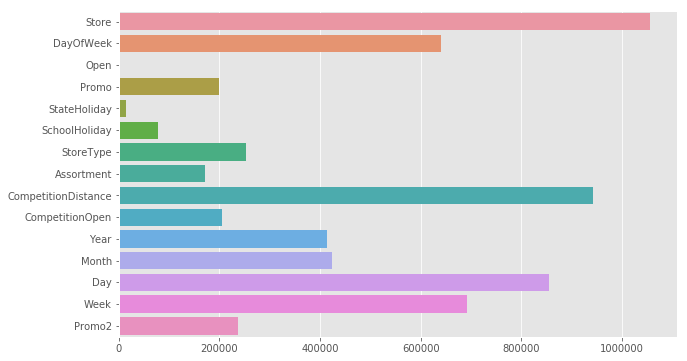

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x=reg.feature_importance(), y=reg.feature_name())

### Make submission

In [29]:
y_pred = np.exp(reg.predict(data_test)) - 1
y_pred = pd.Series(y_pred, name='Sales')
sub = pd.concat([test['Id'], y_pred], axis=1)
sub.to_csv('sub.csv', index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 